# Import Modules

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset

# Make Dataset

In [2]:
# make dataset

import pickle, gzip

with gzip.open('C:/Users/OWNER/Desktop/mnist.pkl.gz', 'rb') as f:
    ((x_train, y_train), (x_test, y_test), _) = pickle.load(f, encoding="latin-1")
    
batch_size = 16

x_train, y_train, x_test, y_test = map(torch.tensor,
                                       (x_train, y_train, x_test, y_test))

train_ds = TensorDataset(x_train, y_train)
test_ds = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_ds, batch_size=batch_size)
test_loader = DataLoader(test_ds, batch_size=batch_size)

# Declare # of layers

In [3]:
# num of layers
layer_type = {
    '2layers': [64],
    '3layers': [128, 64],
    '4layers': [256, 128, 64],
    '5layers': [512, 256, 128, 64],
}

# Define Multi-Layer Class

In [4]:
# define class
class Net(nn.Module):
    def __init__(self, num_layers, num_classes=10):
        super(Net, self).__init__()
        self.in_features = 28 * 28
        self.num_classes = num_classes
        
        self.layers = self.make_layers(layer_type[num_layers])

    def forward(self, x):
        x = self.layers(x)
        return x

    def make_layers(self, architecture):
        layers = []
        in_features = self.in_features
        
        for x in architecture:
            out_features = x
            layers += [nn.Linear(in_features, out_features), nn.ReLU()]
            in_features = out_features
            
        layers += [nn.Linear(in_features, self.num_classes)]
        
        return nn.Sequential(*layers)
    

# Define Each Model ( 2 to 5 layer )

In [5]:
model2, model3, model4, model5 = Net('2layers'),Net('3layers'),Net('4layers'),Net('5layers')
models = [model2, model3, model4, model5]

model2_cost, model3_cost, model4_cost, model5_cost = [[] for _ in range(4)] 
model2_acc, model3_acc, model4_acc, model5_acc = [[] for _ in range(4)] 

model_cost = [model2_cost, model3_cost, model4_cost, model5_cost]
model_acc = [model2_acc, model3_acc, model4_acc, model5_acc]

# Train Each Model

In [6]:
lr = 1e-2
epochs = 21
criterion = nn.CrossEntropyLoss()

def get_acc(pred, label):
    preds = torch.argmax(pred, dim = 1)
    return (label == preds).float().mean()

for i, model in enumerate(models):
    print(f"{i+2} layer model")
    print("=============================")
    optimizer = optim.SGD(model.parameters(), lr = lr)
    losses = []
    accs = []
    for epoch in range(epochs):
        for batch_idx, (data, label) in enumerate(train_loader):
            pred = model(data)
            
            optimizer.zero_grad()
            
            loss = criterion(pred, label)
            losses.append(loss)
            
            accuracy = get_acc(pred, label)
            accs.append(accuracy)
            
            loss.backward()
            optimizer.step()
        cost = sum(losses)/len(losses)
        model_cost[i].append(cost)
        
        acc = sum(accs)/len(accs)
        model_acc[i].append(acc)
        
        if epoch % 4 == 0:
            print(f"{epoch}: cost = {cost:.4f}  acc = {acc:.4f}")
    print("\n")

2 layer model
0: cost = 0.7136  acc = 0.8247
4: cost = 0.3644  acc = 0.9023
8: cost = 0.2851  acc = 0.9223
12: cost = 0.2399  acc = 0.9343
16: cost = 0.2092  acc = 0.9425
20: cost = 0.1867  acc = 0.9487


3 layer model
0: cost = 0.8520  acc = 0.7641
4: cost = 0.3666  acc = 0.8970
8: cost = 0.2608  acc = 0.9264
12: cost = 0.2061  acc = 0.9418
16: cost = 0.1713  acc = 0.9517
20: cost = 0.1466  acc = 0.9588


4 layer model
0: cost = 1.2008  acc = 0.6298
4: cost = 0.4239  acc = 0.8729
8: cost = 0.2775  acc = 0.9175
12: cost = 0.2080  acc = 0.9386
16: cost = 0.1656  acc = 0.9515
20: cost = 0.1368  acc = 0.9603


5 layer model
0: cost = 1.6628  acc = 0.4477
4: cost = 0.5055  acc = 0.8395
8: cost = 0.3105  acc = 0.9028
12: cost = 0.2231  acc = 0.9310
16: cost = 0.1732  acc = 0.9467
20: cost = 0.1415  acc = 0.9566




# Loss, Accuracy Graph

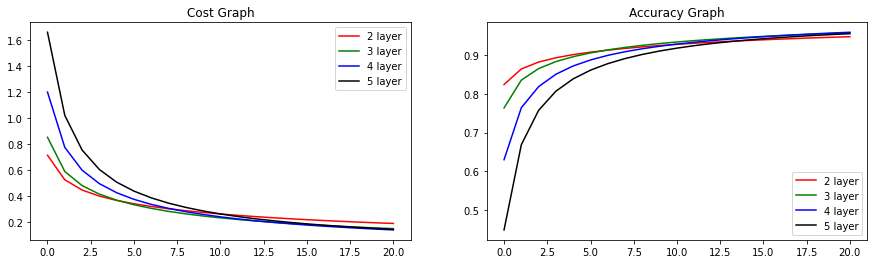

In [7]:
# Loss, Accuracy Graph
import matplotlib.pyplot as plt
import numpy as np
colors = ['r','g','b', 'black']
labels = ['2 layer', '3 layer', '4 layer', '5 layer']

plt.figure(figsize = (15,4))
plt.subplot(121)
for cost, color, label in zip(model_cost, colors, labels):
    plt.plot(np.arange(len(cost)), cost, color = color, label = label)
plt.legend()
plt.title("Cost Graph")
plt.subplot(122)
for acc, color, label in zip(model_acc, colors, labels):
    plt.plot(np.arange(len(acc)), acc, color = color, label = label)
plt.legend()
plt.title("Accuracy Graph")
plt.show()


# Test 1 Mini-Batch

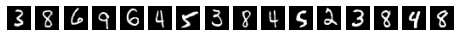

Groung Truth
   3   8   6   9   6   4   5   3   8   4   5   2   3   8   4   8
Prediction
   3   8   6   9   6   4   5   3   8   4   5   2   3   8   4   8


In [8]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

plt.figure(figsize = (8,16*8))
for i in range(16):
    plt.subplot(1,16,i+1)
    plt.imshow(images[i].reshape((28,28)), cmap = 'gray')
    plt.axis('off')
plt.show()
print("Groung Truth")
print(" "+' '.join('%3s' %label.item() for label in labels))
outputs = model(images)
_, predicted = torch.max(outputs, 1)
print("Prediction")
print(" "+' '.join('%3s' %label.item() for label in predicted))

# Test Accuracy

2 layer model Accuracy = 0.9696
3 layer model Accuracy = 0.9721
4 layer model Accuracy = 0.9735
5 layer model Accuracy = 0.9740


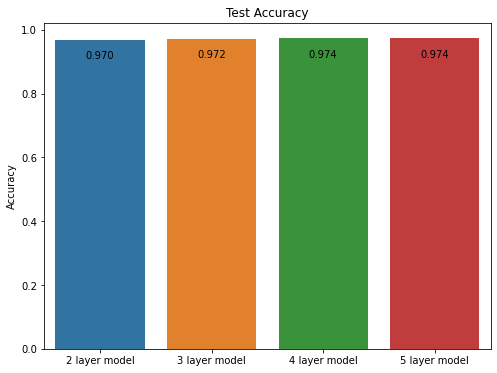

In [9]:
import seaborn as sns
n_predict = 0
n_correct = 0
test_acc = []
for i, model in enumerate(models):

    for data, label in test_loader:
        outputs = model(data)
        _, predicted = torch.max(outputs, 1)

        n_predict += len(predicted)
        n_correct += (label == predicted).sum()
    acc = n_correct / n_predict
    test_acc.append(acc)

    print(f"{i+2} layer model Accuracy = {acc:.4f}")

# Accuracy Graph with each model
x = np.arange(4)
plt.figure(figsize=(8, 6))
plt.title("Test Accuracy")
plt.ylabel("Accuracy")
ax = sns.barplot(x, test_acc)
for p in ax.patches:
    ax.annotate("%.3f" % p.get_height(),
                (p.get_x() + p.get_width() / 2., p.get_height() - 0.05),
                ha='center',
                va='center',
                fontsize=10,
                color='black')
plt.xticks(x, [f"{i} layer model" for i in range(2, 6)])
plt.show()